# Quantum Convolution Network

https://qiskit.org/ecosystem/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

[1] Cong, I., Choi, S. & Lukin, M.D. Quantum convolutional neural networks. Nat. Phys. 15, 1273–1278 (2019). https://doi.org/10.1038/s41567-019-0648-8

[2] IBM Convolutional Neural Networks https://www.ibm.com/cloud/learn/convolutional-neural-networks

[3] Vatan, Farrokh, and Colin Williams. “Optimal quantum circuits for general two-qubit gates.” Physical Review A 69.3 (2004): 032315.

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

/var/folders/4z/946_ygn50p3bc_rsjbq9cg240000gn/T/ipykernel_86260/3715458721.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B


Classical Convolutional Neural Networks (CCNNs) are a subclass of artificial neural networks which have the ability to determine particular features and patterns of a given input. Because of this, they are commonly used in image recognition and audio processing.

The capability of determining features is a result of the two types of layers used in a CCNN, the convolutional layer and pooling layer.

## Quantum CNN

Quantum Convolutional Neural Networks (QCNN) behave in a similar manner to CCNNs. First, we encode our pixelated image into a quantum circuit using a given feature map, such Qiskit’s ZFeatureMap or ZZFeatureMap or others available in the circuit library.

After encoding our image, we apply alternating convolutional and pooling layers, as defined in the next section. By applying these alternating layers, we reduce the dimensionality of our circuit until we are left with one qubit. We can then classify our input image by measuring the output of this one remaining qubit.



![image](images/qcnn-structure-basic.png)

![imagess](images/two-parameter-circuit.png)

## Convolution Layer

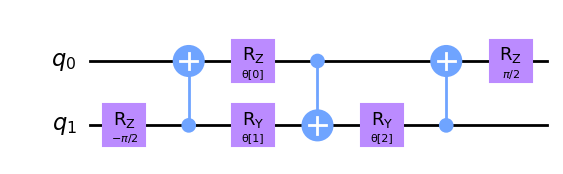

In [7]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

Now that we have defined these unitaries, it is time to create a function for the convolutional layer in our QCNN. To do so, we apply the two qubit unitary to neighboring qubits as seen in the conv_layer function below.

Note that we first apply the two qubit unitary to all even pairs of qubits followed by applying to odd pairs of qubits in a circular coupling manner, i.e. the as well as neighboring qubits being coupled, the first and final qubit are also coupled through a unitary gate.

Note that we add barriers into our quantum circuits for convenience when plotting, however they are not required for the actual QCNN and can be extracted from the following circuits.



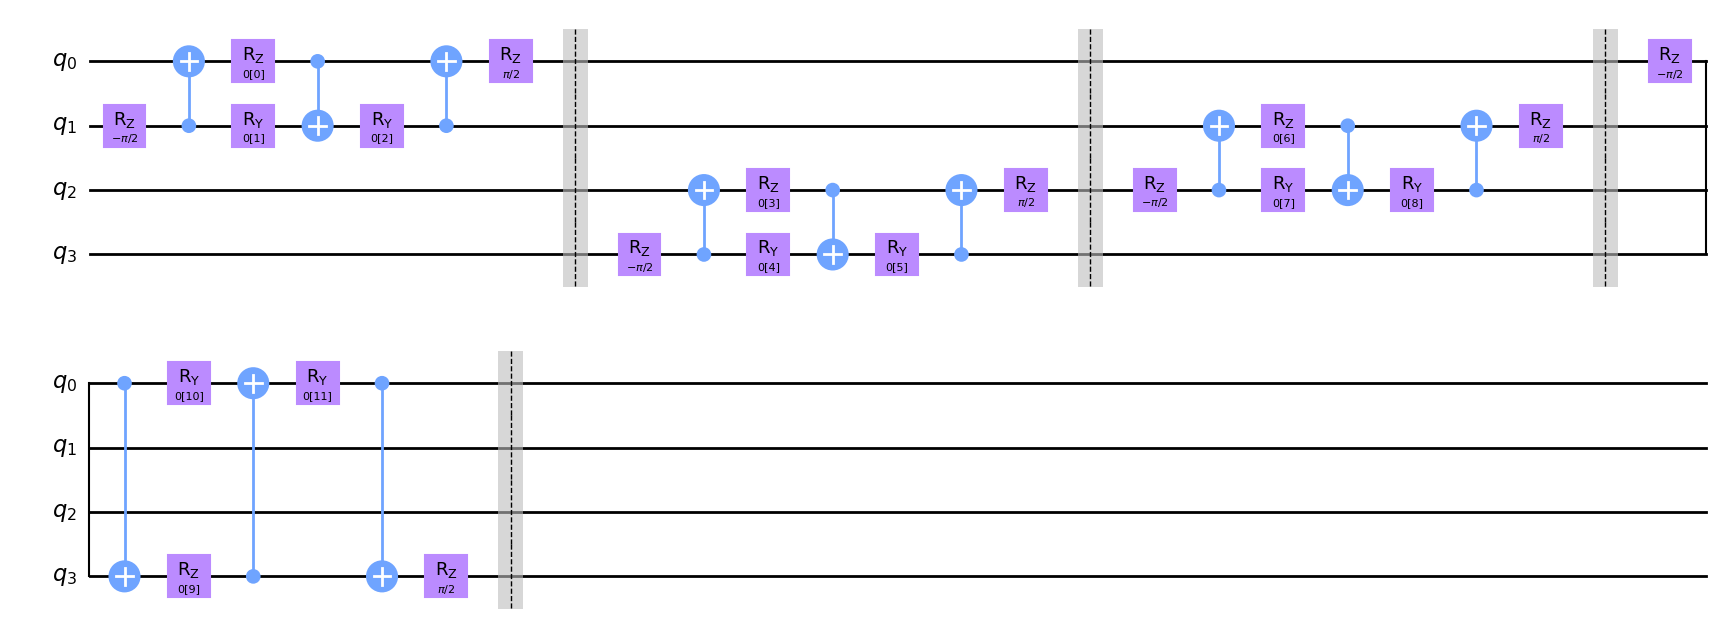

In [10]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "0")
circuit.decompose().draw("mpl")

## Pooling Layer

The purpose of a pooling layer is to reduce the dimensions of our Quantum Circuit, i.e. reduce the number of qubits in our circuit, while retaining as much information as possible from previously learned data. Reducing the amount of qubits also reduces the computational cost of the overall circuit, as the number of parameters that the QCNN needs to learn decreases.

However, one cannot simply decrease the amount of qubits in our quantum circuit. Because of this, we must define the pooling layer in a different manner compared with the classical approach.

To ‘artificially’ reduce the number of qubits in our circuit, we first begin by creating pairs of the 
 qubits in our system.

After initially pairing all the qubits, we apply our generalized 2 qubit unitary to each pair, as described previously. After applying this two qubit unitary, we then ignore one qubit from each pair of qubits for the remainder of the neural network.

This layer therefore has the overall effect of ‘combining’ the information of the two qubits into one qubit by first applying the unitary circuit, encoding information from one qubit into another, before disregarding one of qubits for the remainder of the circuit and not performing any operations or measurements on it.

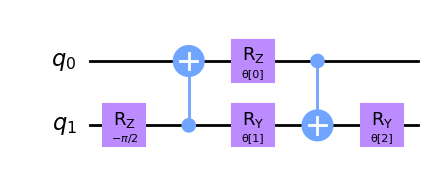

In [18]:
# Defining pooling that will reduce the number of qbits(N)) at each application by half (N/2).
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

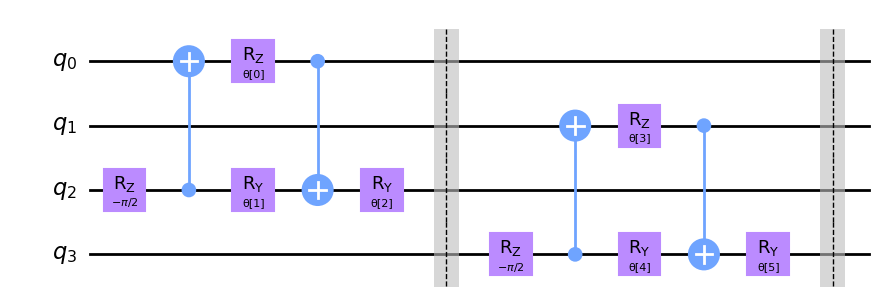

In [19]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

## Data Generation

In [18]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [57]:
# splitting dataset
images, labels = generate_dataset(10)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

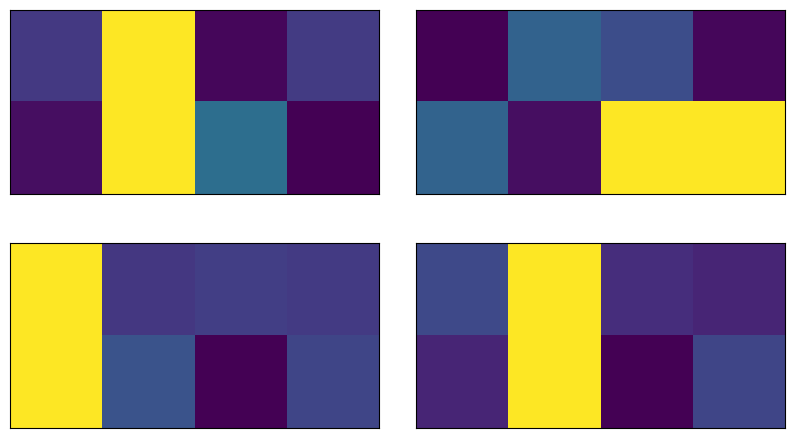

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

## Modelling the QNN

Now that we have defined both the convolutional layers it is now time to build our QCNN, which will consist of alternating pooling and convolutional layers.

As the images in our dataset contains 8 pixels, we will use 8 qubits in our QCNN.

We encode our dataset into our QCNN by applying a feature map. One can create a feature map using one of Qiskit’s built in feature maps, such as ZFeatureMap or ZZFeatureMap.

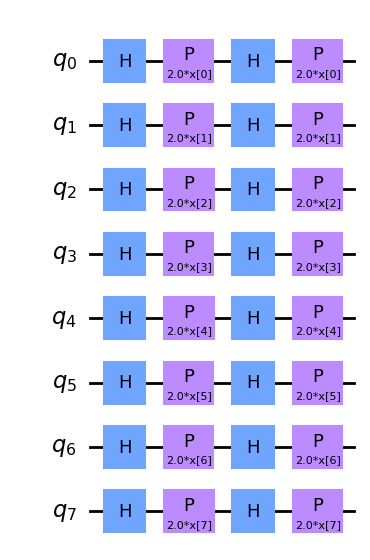

In [59]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl")

Visual representation of the final setup.

![image](images/8-qbit-qcnn.png)

## Training

In [20]:
feature_map = ZFeatureMap(8) # feature map

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

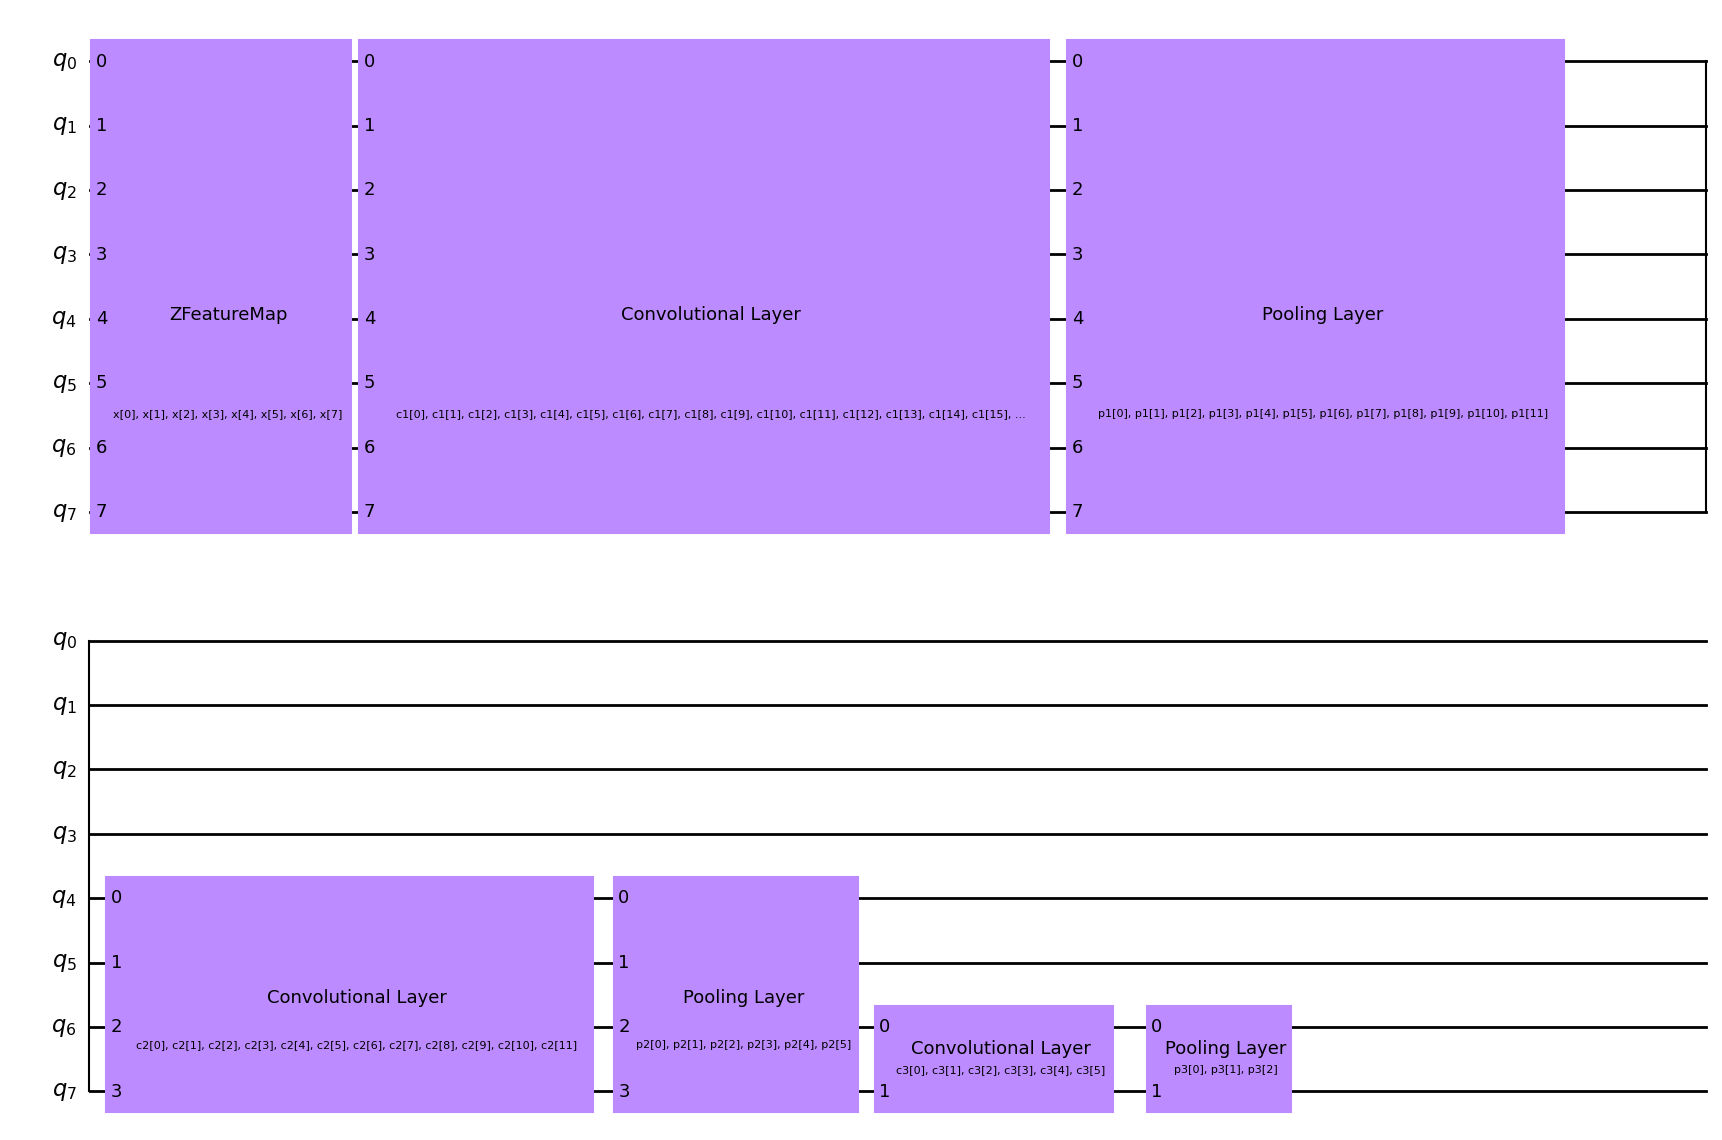

In [21]:
circuit.draw("mpl")


In [62]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [27]:
## Change the classifier to regressor, and change the loss function

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=400),  # Set max iterations here
    callback=callback_graph,
    # initial_point=initial_point,
)

In [63]:
regressor = NeuralNetworkRegressor(
    neural_network=qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=400),
    callback=callback_graph,
)

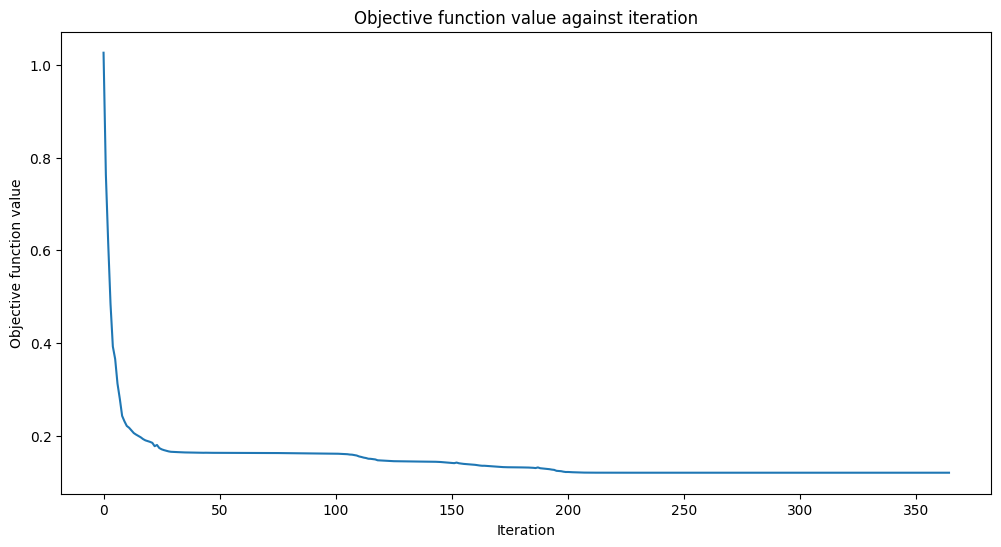

Accuracy from the train data : 87.78%


In [64]:
x = np.asarray(train_images)
y = np.asarray(train_labels) # multiple columns

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
# classifier.fit(x, y)
regressor.fit(x,y)
# score classifier
# print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
print(f"Accuracy from the train data : {np.round(100 * regressor.score(x, y), 2)}%")

## Testing the QCNN

Accuracy from the test data : 66.67%


IndexError: list index out of range

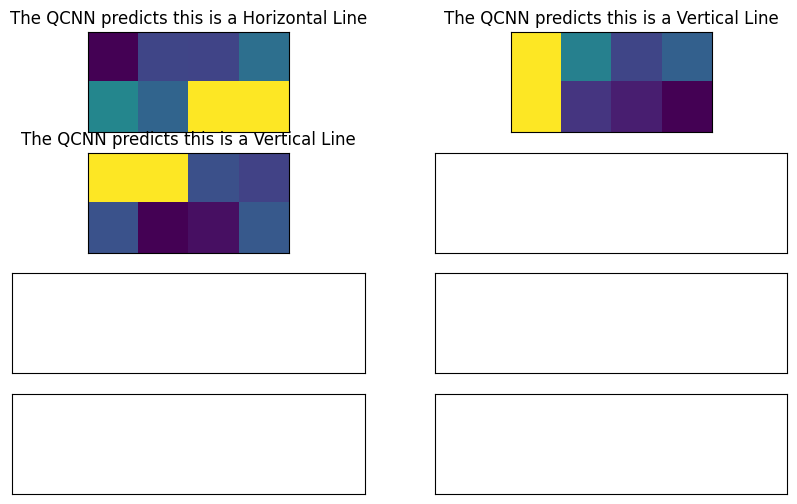

In [66]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(4, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 8):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [13]:
no_of_features = 8

In [14]:
def split_integer_into_lists(no_of_features):
    # Calculate half of the integer
    half = no_of_features // 2
    
    # Create two lists based on half
    list1 = list(range(half))
    list2 = list(range(half, no_of_features))
    
    return list1, list2

In [39]:
no_of_features = 16
feature_map = ZFeatureMap(no_of_features) # feature map

ansatz = QuantumCircuit(no_of_features, name="Ansatz")
counter = 1

start_point = no_of_features
while start_point % 2 == 0:
    
    # Convolutional Layer
    ansatz.compose(conv_layer(start_point, f"с{counter}"), list(range(start_point)), inplace=True)

    sources = split_integer_into_lists(start_point)[0]
    sinks = split_integer_into_lists(start_point)[1]
    ansatz.compose(pool_layer(sources, sinks, f"p{counter}"), list(range(start_point)), inplace=True)

    counter += 1
    start_point = start_point // 2

# Combining the feature map and ansatz
circuit = QuantumCircuit(no_of_features)
circuit.compose(feature_map, range(no_of_features), inplace=True)
circuit.compose(ansatz, range(no_of_features), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * no_of_features, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

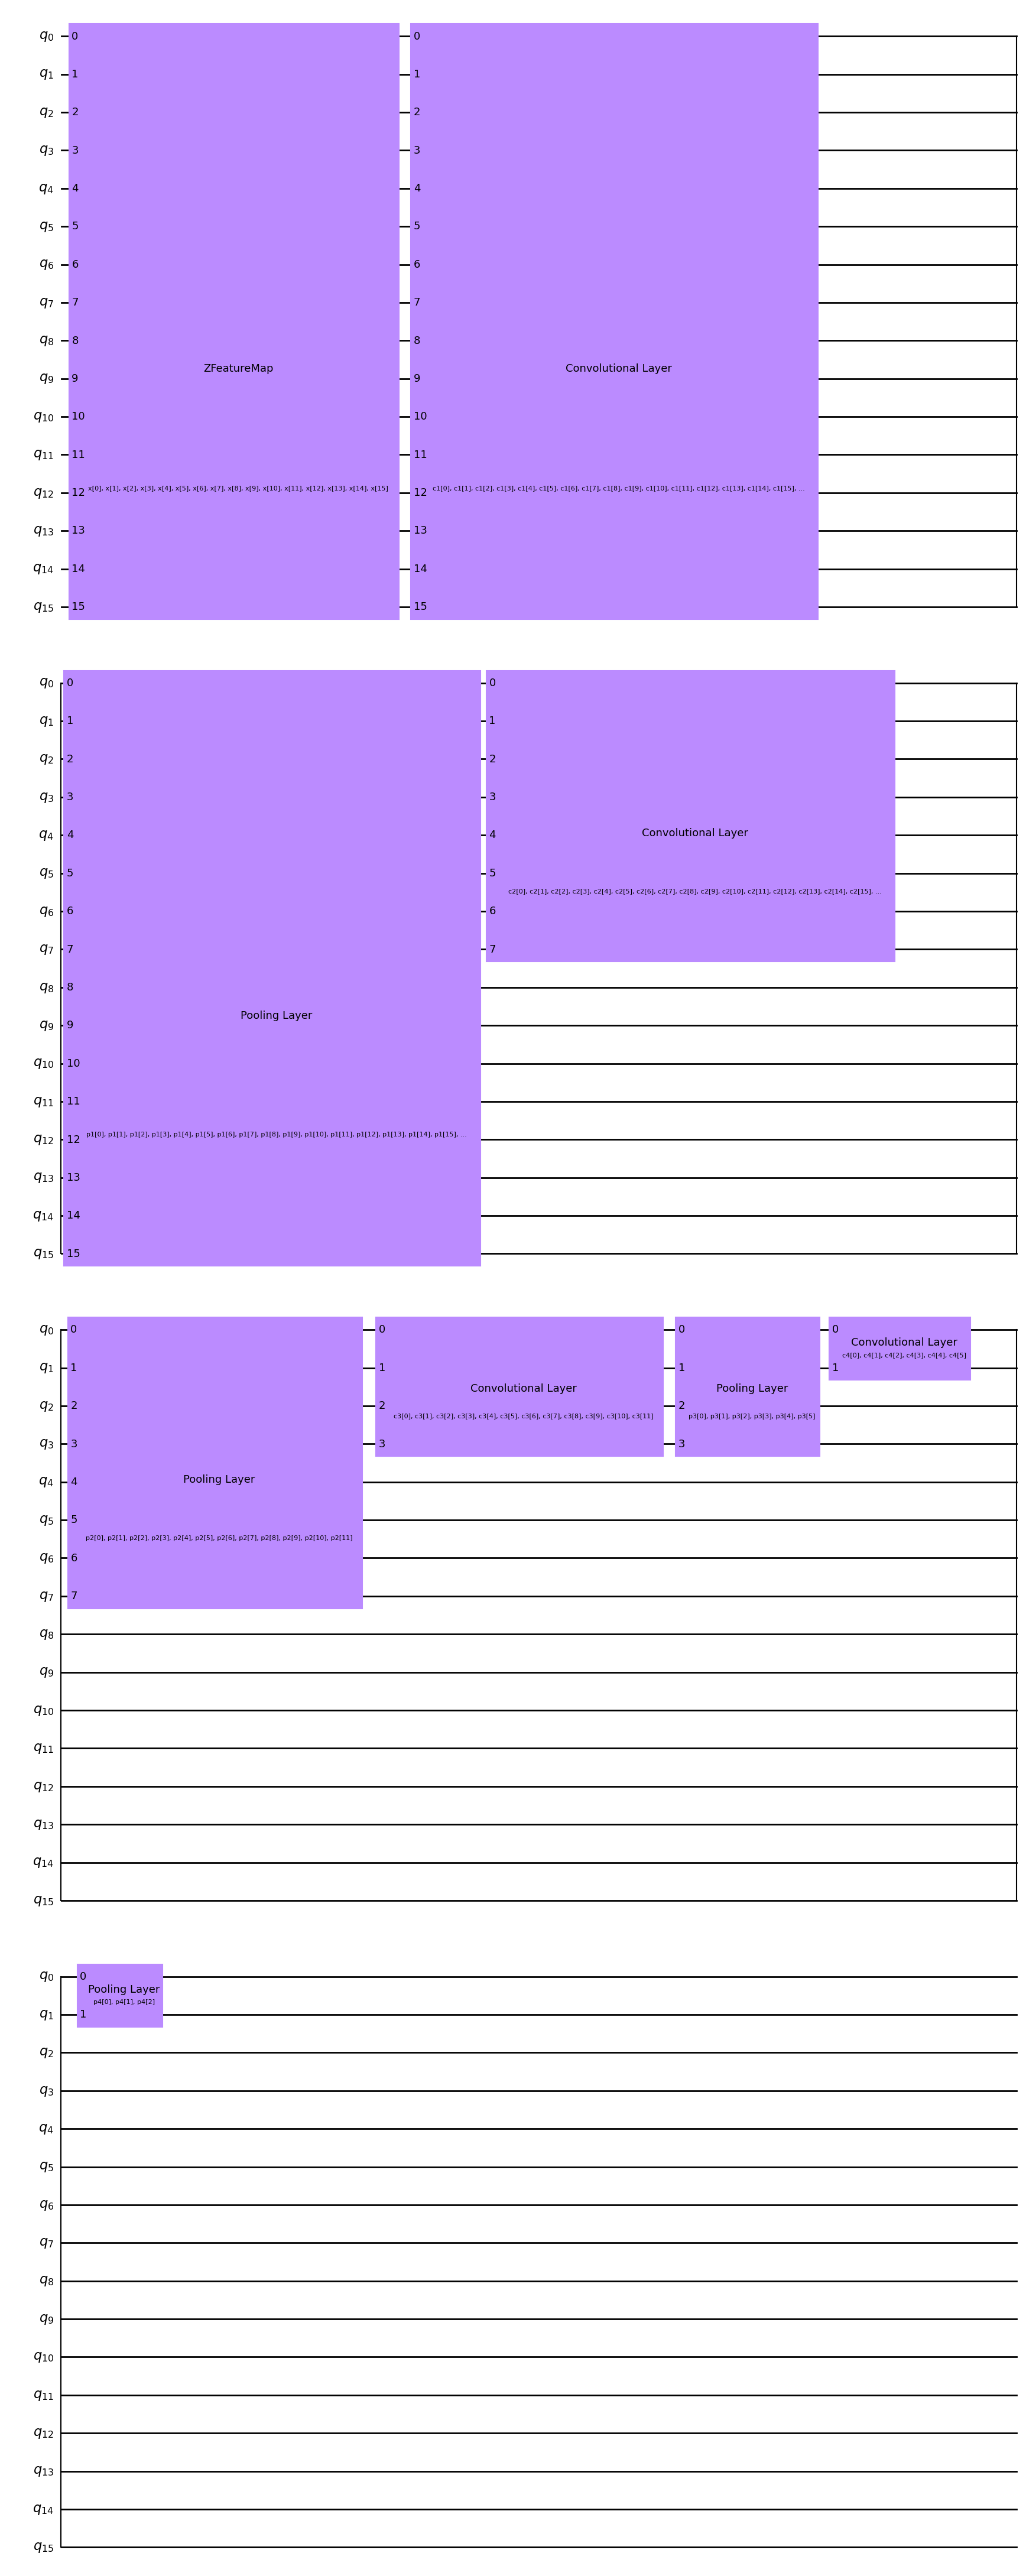

In [40]:
circuit.draw("mpl")

In [41]:
observable

SparsePauliOp(['ZIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])

In [42]:
observable.num_qubits

17

In [43]:
from qiskit_machine_learning.algorithms import QSVC